In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from enum import Enum
from typing import Any, List

In [2]:
pillbox = np.load('images/pillbox.npy')
test = np.load('images/test.npy')
line = np.load('images/line.npy')

pillbox_hough = np.load('images/pillbox_hough.npy')
test_hough = np.load('images/test_hough.npy')
line_hough = np.load('images/line_hough.npy')

pillbox_background = np.load('images/pillbox_background.npy')
test_background = np.load('images/test_background.npy')
line_background = np.load('images/line_background.npy')

In [3]:
get_labels = lambda img: cv2.connectedComponents(img, connectivity = 4)[1]

pillbox_labels = get_labels(pillbox_background)
test_labels = get_labels(test_background)
line_labels = get_labels(line_background)

In [4]:
from scipy.stats import mode

def filter_labels(labels, img):
    flatten_labels = labels.flatten()
    unique_labels = np.array(list(set(labels.flatten())))
    flatten_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).flatten()
    filtered_labels = []
    
    for label in unique_labels:
        region_mode = mode(flatten_img[flatten_labels == label])[0]
        if region_mode != 0:
            filtered_labels.append(label)
            
    return filtered_labels



def plot_roi(labels, filtered_labels, img):
    
    fig, axs = plt.subplots(4, 4, figsize = (10, 10))
    
    for i, label in enumerate(filtered_labels):
        roi = img.copy()
        roi[labels != label] = 0
        
        axs[i // 4][i % 4].imshow(roi)
        axs[i // 4][i % 4].set_title(f'Label no. {label}')
        axs[i // 4][i % 4].axis('off')
    
    fig.tight_layout()
    plt.show()



def single_roi(img, labels, k):
    roi = img.copy()
    roi[labels != k] = 0
    return roi

In [5]:
pillbox_flabels = filter_labels(pillbox_labels, pillbox)
test_flabels = filter_labels(test_labels, test)
line_flabels = filter_labels(line_labels, line)

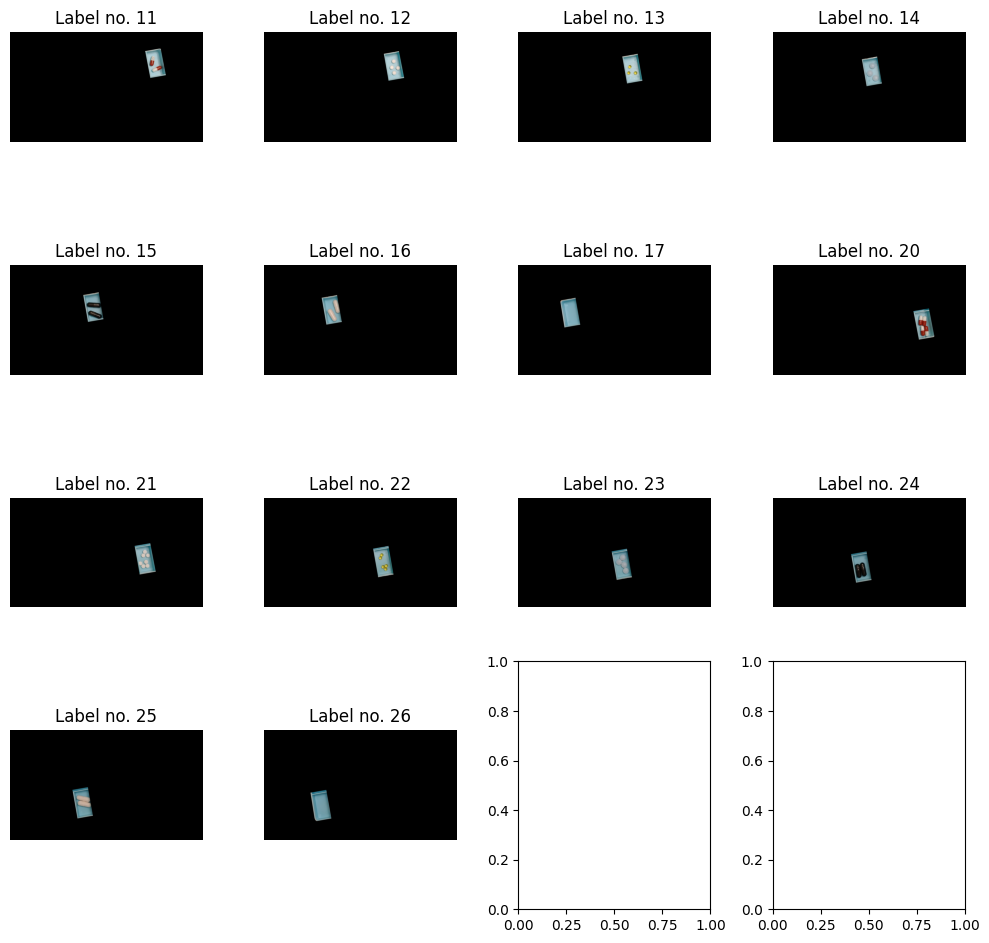

In [50]:
plot_roi(pillbox_labels, pillbox_flabels, pillbox)

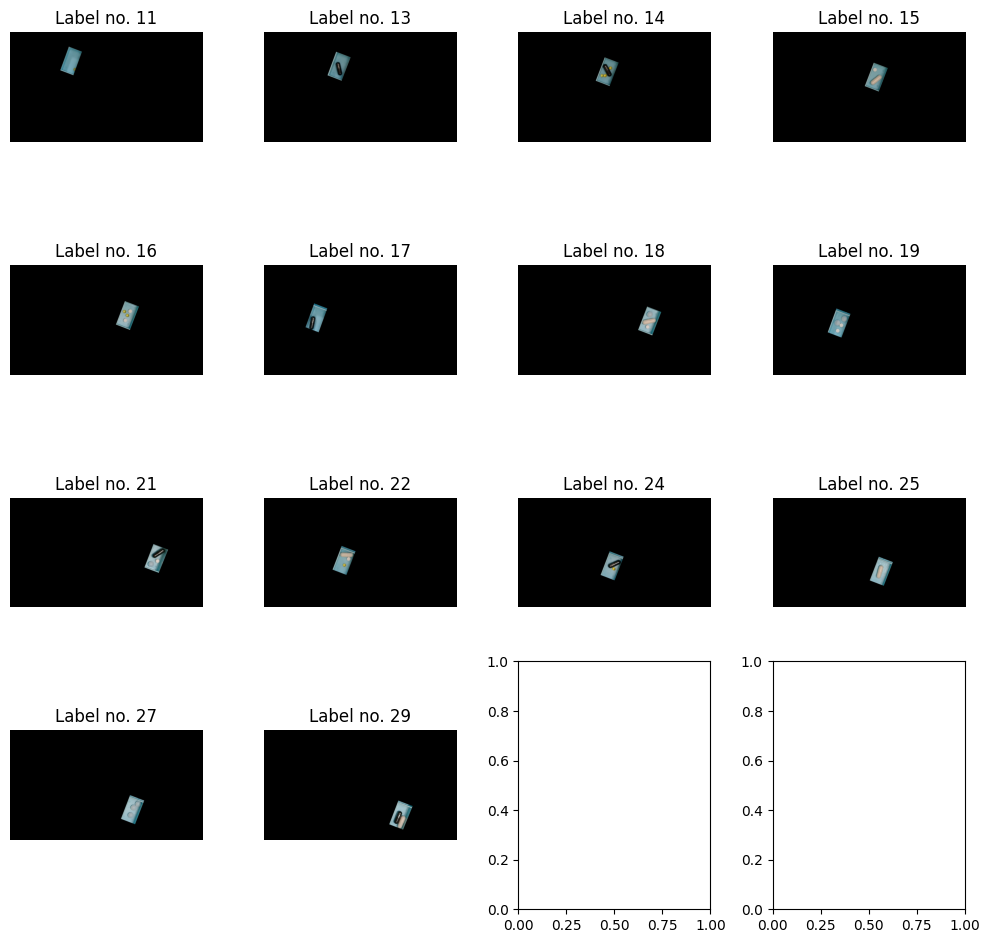

In [51]:
plot_roi(test_labels, test_flabels, test)

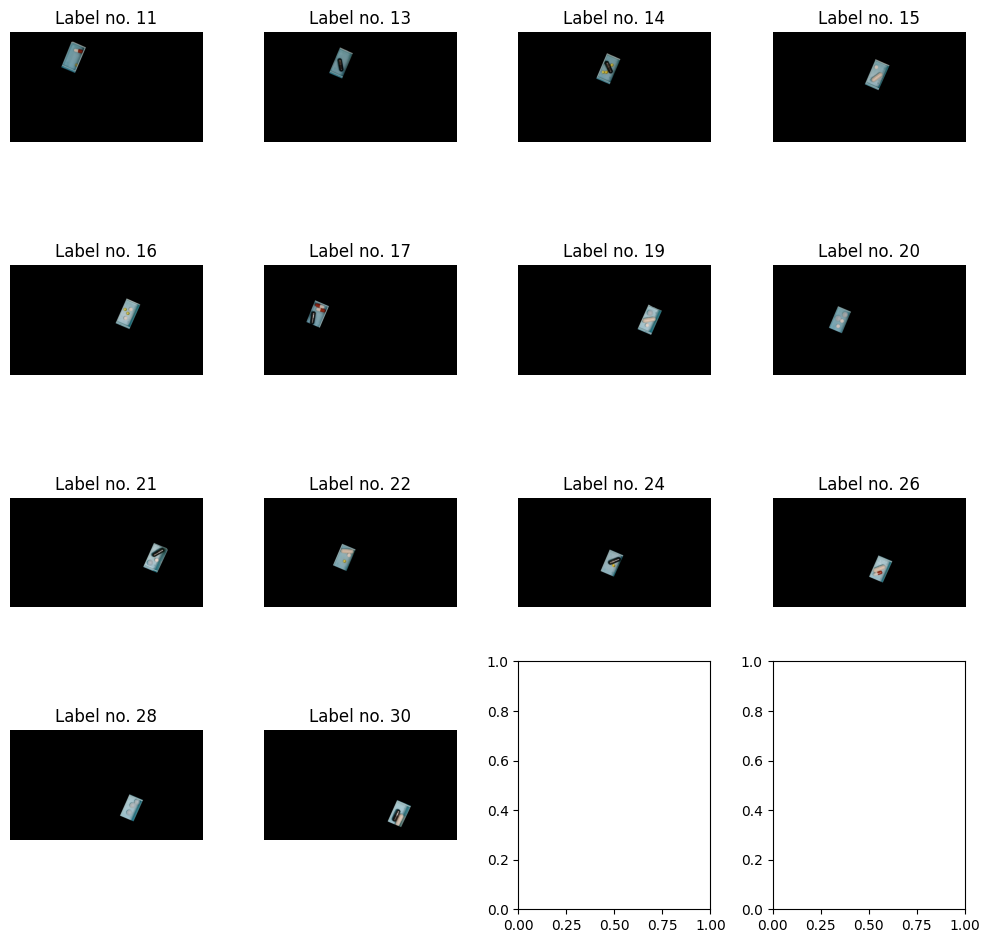

In [52]:
plot_roi(line_labels, line_flabels, line)

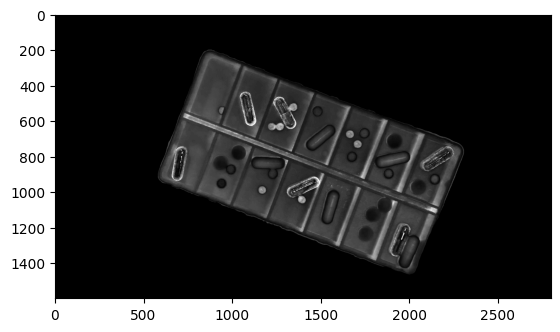

In [17]:
hue = cv2.cvtColor(test, cv2.COLOR_RGB2HLS)[..., 2]
_, hue_bin = cv2.threshold(hue, 95, 180, cv2.THRESH_BINARY_INV)
# hue_morph = cv2.morphologyEx(hue_bin, cv2.MORPH_CLOSE, kernel = np.ones((3, 3)), iterations = 6)
# hue_morph = cv2.morphologyEx(hue_morph, cv2.MORPH_OPEN, kernel = np.ones((3, 3)), iterations = 4)
plt.imshow(hue, cmap = 'gray')
# plt.imshow(hue_bin, cmap='gray')
# plt.imshow(hue_morph, cmap = 'gray')

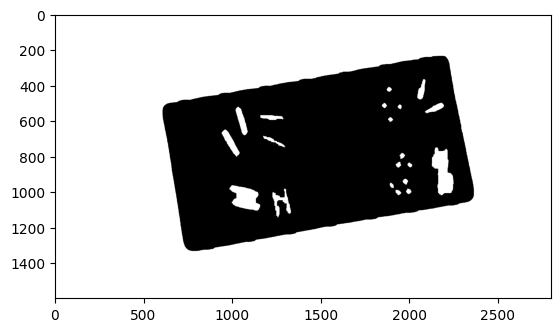

In [649]:
aa = cv2.threshold(cv2.cvtColor(pillbox, cv2.COLOR_RGB2HSV)[..., 0], 20, 180, cv2.THRESH_BINARY_INV)[1]
aaa = cv2.morphologyEx(aa, cv2.MORPH_DILATE, np.ones((3, 3), np.uint8), iterations = 3)
aaa = cv2.morphologyEx(aaa, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8), iterations = 12)
plt.imshow(aaa ,cmap='gray')

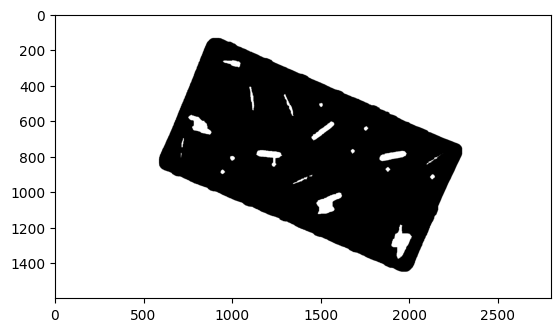

In [658]:
aa = cv2.threshold(cv2.cvtColor(line, cv2.COLOR_RGB2HSV)[..., 0], 20, 180, cv2.THRESH_BINARY_INV)[1]
aaa = cv2.morphologyEx(aa, cv2.MORPH_DILATE, np.ones((3, 3), np.uint8), iterations = 3)
aaa = cv2.morphologyEx(aaa, cv2.MORPH_ERODE, np.ones((3, 3), np.uint8), iterations = 12)
plt.imshow(aaa ,cmap='gray')

In [651]:
num_labels, labels = cv2.connectedComponents(aaa, connectivity=4)
sizes = np.bincount(labels.ravel())
labels
# hue_comp = aaa.copy()
# hue_comp[labels == np.argmax(sizes)] = 0
# plt.imshow(hue_comp, cmap = 'gray')

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [106]:
def detect_biox(roi, dest_img):
    dest_img = dest_img.copy()
    GRAY = roi[..., 0]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 5, param2 = 30,
                                minRadius = 26, maxRadius = 33)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 0, 255), 3)

    return dest_img

In [107]:
def detect_epsu(roi, dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.threshold(cv2.cvtColor(roi, cv2.COLOR_RGB2LAB)[..., 2], 167, 255, cv2.THRESH_BINARY)[1]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 20,
                                param1 = 30, param2 = 7,
                                minRadius = 3, maxRadius = 25)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (255, 255, 0), 3)

    return dest_img

In [108]:
def detect_keto(roi, dest_img):
    dest_img = dest_img.copy()
    GRAY = cv2.cvtColor(roi, cv2.COLOR_RGB2HLS)[..., 2]
    CIRCLES = cv2.HoughCircles(GRAY, cv2.HOUGH_GRADIENT, 1, 25,
                                param1 = 30, param2 = 26,
                                minRadius = 40, maxRadius = 50)

    if CIRCLES is not None:
        CIRCLES = np.uint16(np.around(CIRCLES))
        for i in CIRCLES[0, :]:
            center = (i[0], i[1])
            cv2.circle(dest_img, center, 1, (0, 100, 100), 3)
            radius = i[2]
            cv2.circle(dest_img, center, radius, (0, 0, 255), 3)

    return dest_img

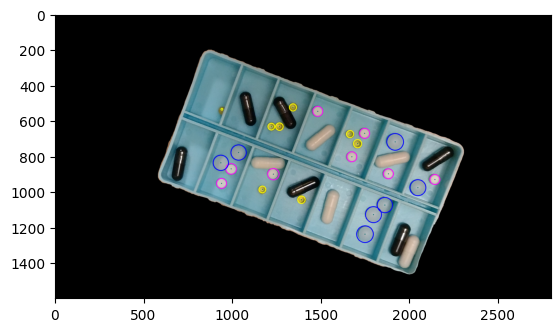

In [109]:
output = test.copy()
for label in test_flabels:
    roi = single_roi(test, test_labels, label)
    output = detect_biox(roi, output)
    output = detect_epsu(roi, output)
    output = detect_keto(roi, output)

plt.imshow(output)

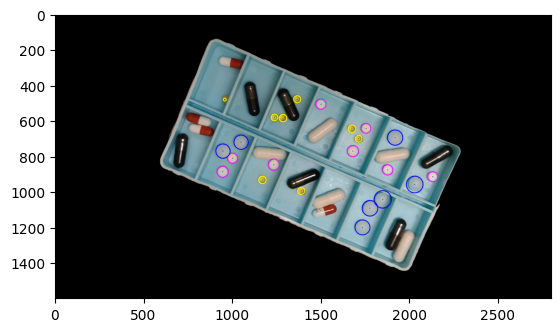

In [110]:
output = line.copy()
for label in line_flabels:
    roi = single_roi(line, line_labels, label)
    output = detect_biox(roi, output)
    output = detect_epsu(roi, output)
    output = detect_keto(roi, output)

plt.imshow(output)

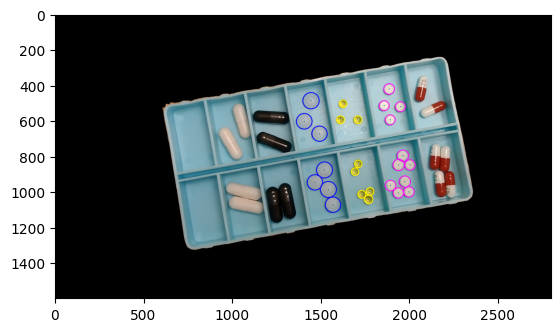

In [111]:
output = pillbox.copy()
for label in pillbox_flabels:
    roi = single_roi(pillbox, pillbox_labels, label)
    output = detect_biox(roi, output)
    output = detect_epsu(roi, output)
    output = detect_keto(roi, output)

plt.imshow(output)